## Data Sourcing and Structure
### Reading and tagging Miami, Tampa, and Philly datasets

In [0]:
%python
%pip install azure-storage-blob pandas matplotlib seaborn ipywidgets

from azure.storage.blob import BlobServiceClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import ipywidgets as widgets
from io import StringIO

# Azure storage account details
connection_string = "DefaultEndpointsProtocol=https;AccountName=healthcaredatastore;AccountKey=roKT3df915NsRDAGMFQhXIZgVIstGL+k3yUKM4IQojZkaLjywwAhqaUWKgT32Vb1ioWq5CgTsIu5+AStnKGG6Q==;EndpointSuffix=core.windows.net"
container_name = "hospital"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)

# Function to read blob data into a pandas DataFrame
def read_blob_to_df(blob_name):
    blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)
    blob_data = blob_client.download_blob().content_as_text()
    return pd.read_csv(StringIO(blob_data), dtype={'standard_charge|negotiated_dollar': 'str'}, low_memory=False)

# Load the files
miami_df = read_blob_to_df('Miami_data.csv')
philly_df = read_blob_to_df('Philly_data.csv')
tampa_df = read_blob_to_df('Tampa_data.csv')

# Add region column
miami_df['region'] = 'Miami'
philly_df['region'] = 'Philadelphia'
tampa_df['region'] = 'Tampa'

# Combine the datasets
combined_df = pd.concat([miami_df, philly_df, tampa_df], ignore_index=True)

# Remove unnamed columns
combined_df = combined_df.loc[:, ~combined_df.columns.str.contains('^Unnamed')]

# Preview the combined data
display(combined_df.head())

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.0/407.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.4/207.4 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-63539f4b-cfdf-432f-918a-50521f5dc8ba
    Can't uninstall 'typing_extensions'. No files were found to uninstall.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


hospital_name,description,setting,payer_name,plan_name,standard_charge|negotiated_dollar,cpt_code,region
Bapist hospital,OneBlood CBC w auto diff,both,DIMENSION HEALTH PLAN,DIMENSION 2,22.5,85025,Miami
Bapist hospital,Orbit face neck MRI wwo con,both,DIMENSION HEALTH PLAN,DIMENSION 2,5562.9,70543,Miami
Bapist hospital,Orbit sella pf ear ct w con UC,both,DIMENSION HEALTH PLAN,DIMENSION 2,5360.4,70481,Miami
Bapist hospital,Orbit sella pf ear ct wo c UC,both,DIMENSION HEALTH PLAN,DIMENSION 2,4953.6,70480,Miami
Bapist hospital,Orbit sella pf ear CT wo con|PET Orbit sella pf ear CT wo con,both,DIMENSION HEALTH PLAN,DIMENSION 2,4646.7,70480,Miami


## Exploratory Data Analysis (EDA)
### Summary of missing values, unique entries, and data types

In [0]:
print(combined_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231474 entries, 0 to 2231473
Data columns (total 8 columns):
 #   Column                             Dtype 
---  ------                             ----- 
 0   hospital_name                      object
 1   description                        object
 2   setting                            object
 3   payer_name                         object
 4   plan_name                          object
 5   standard_charge|negotiated_dollar  object
 6   cpt_code                           object
 7   region                             object
dtypes: object(8)
memory usage: 136.2+ MB
None


In [0]:
# Understanding the data and unique field count
print(combined_df.nunique())

hospital_name                            16
description                           79170
setting                                   6
payer_name                              157
plan_name                               222
standard_charge|negotiated_dollar    226198
cpt_code                              12810
region                                    3
dtype: int64


In [0]:
# Checking if there are any missing values in the data
print(combined_df.isnull().sum())

hospital_name                        0
description                          0
setting                              0
payer_name                           0
plan_name                            0
standard_charge|negotiated_dollar    0
cpt_code                             0
region                               0
dtype: int64


In [0]:
# Sampling the data for test code and visual analysis
sample_df = combined_df.sample(10000, random_state=1)
print(sample_df.nunique())

hospital_name                          16
description                          8054
setting                                 6
payer_name                            154
plan_name                             198
standard_charge|negotiated_dollar    7683
cpt_code                             4294
region                                  3
dtype: int64


## Analysis

In [0]:
# Hospital Pricing Summary – Grouped by Region and Sorted by Average Price
combined_df['standard_charge|negotiated_dollar'] = pd.to_numeric(
    combined_df['standard_charge|negotiated_dollar'], errors='coerce'
)

hospital_summary = (
    combined_df.groupby('hospital_name')
    .agg(
        region=('region', 'first'),
        avg_price=('standard_charge|negotiated_dollar', 'mean'),
        cpt_count=('cpt_code', pd.Series.nunique),
        payer_count=('payer_name', pd.Series.nunique)
    )
    .round(2)
    .sort_values(by=['region', 'avg_price'], ascending=[True, True])
)
pd.set_option('display.width', 200)  # or any number you prefer

print(hospital_summary)

                                            region  ...  payer_count
hospital_name                                       ...             
University of Miami                          Miami  ...            9
Boca Raton                                   Miami  ...            9
Broward Health Coral Springs                 Miami  ...            7
Bapist hospital                              Miami  ...           21
Christiana Hospital                   Philadelphia  ...           27
Childrens Hospital of Philadelphia    Philadelphia  ...           23
Thomas-jefferson-university-hospital  Philadelphia  ...           44
Inspira-health-centre                 Philadelphia  ...           14
Albert Einstein Medical Center        Philadelphia  ...           20
Virtua-our-lady-of-lourdes            Philadelphia  ...           11
Mariners Hospital                            Tampa  ...           22
Fishermens Health                            Tampa  ...           21
DOCTORS HOSPITAL                  

In [0]:
# Group by payer and region, then aggregate
hospital_summary = (
    combined_df
    .groupby(['payer_name', 'region'])
    .agg(
        avg_price=('standard_charge|negotiated_dollar', 'mean'),
        cpt_count=('cpt_code', pd.Series.nunique)
    )
    .round(2)
)

# Pivot to make regions into column headers with 2 metrics
pivoted_summary = hospital_summary.unstack(level='region')

# Optional: clean column names for readability
pivoted_summary.columns = [f"{stat} ({region})" for stat, region in pivoted_summary.columns]

# Display result
print(pivoted_summary.head(10))

                        avg_price (Miami)  ...  cpt_count (Tampa)
payer_name                                 ...                   
AETNA                             2143.85  ...             3935.0
AFFORDABLE                        2887.30  ...             3549.0
AMERIHEALTH                       2654.93  ...             3532.0
APWU                                  NaN  ...                NaN
AVMED                             2618.77  ...             3954.0
Advantra                              NaN  ...                NaN
Aetna                                 NaN  ...                NaN
Aetna                                 NaN  ...                NaN
Aetna Better Health                   NaN  ...                NaN
Aetna Main Line Health                NaN  ...                NaN

[10 rows x 6 columns]


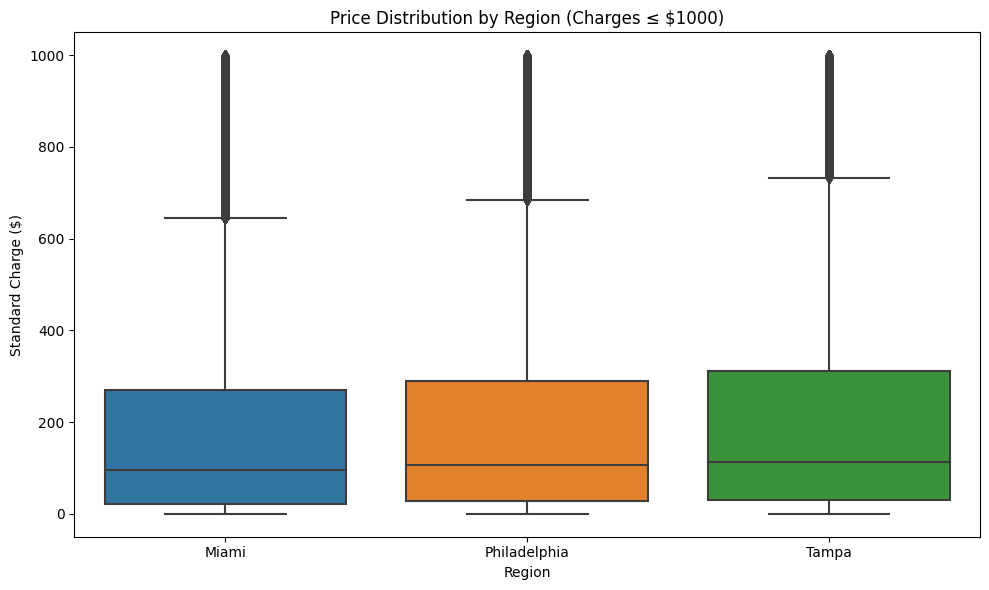

In [0]:
# Filter for charges up to $1000
filtered_df = combined_df[combined_df['standard_charge|negotiated_dollar'] <= 1000]

# Create box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df, x='region', y='standard_charge|negotiated_dollar')
plt.title("Price Distribution by Region (Charges ≤ $1000)")
plt.xlabel("Region")
plt.ylabel("Standard Charge ($)")
plt.tight_layout()
plt.show()

In [0]:
# Create pivot: average charge
avg_charge_pivot = combined_df.pivot_table(
    index='payer_name',
    columns='hospital_name',
    values='standard_charge|negotiated_dollar',
    aggfunc='mean'
).round(2)

# Create pivot: CPT code count
cpt_count_pivot = combined_df.pivot_table(
    index='payer_name',
    columns='hospital_name',
    values='cpt_code',
    aggfunc=pd.Series.nunique
).fillna(0).astype(int)

# Combine the two into formatted string
combined_pivot = avg_charge_pivot.fillna(0).astype(str) + " (" + cpt_count_pivot.astype(str)+ ")"

# Display
combined_pivot

hospital_name,Albert Einstein Medical Center,BETHESDA HOSPITAL,Bapist hospital,Boca Raton,Broward Health Coral Springs,Childrens Hospital of Philadelphia,Christiana Hospital,DOCTORS HOSPITAL,Fishermens Health,Homestead Hospital,Inspira-health-centre,Mariners Hospital,SOUTH MIAMI HOSPITAL,Thomas-jefferson-university-hospital,University of Miami,Virtua-our-lady-of-lourdes
payer_name,,,,,,,,,,,,,,,,
AETNA,0.0 (0),1958.46 (3057),2821.29 (2552),923.76 (3454),0.0 (0),0.0 (0),0.0 (0),2061.83 (2754),1964.71 (765),0.0 (0),0.0 (0),1010.44 (1603),2703.66 (3549),0.0 (0),0.0 (0),0.0 (0)
AFFORDABLE,0.0 (0),5876.29 (3057),5786.4 (2552),1619.99 (3454),0.0 (0),0.0 (0),0.0 (0),0.0 (0),2900.26 (81),0.0 (0),0.0 (0),1690.96 (1493),5339.44 (3157),0.0 (0),0.0 (0),0.0 (0)
AMERIHEALTH,0.0 (0),6900.6 (3058),2654.93 (2552),0.0 (0),0.0 (0),0.0 (0),0.0 (0),866.52 (1330),1557.88 (54),0.0 (0),0.0 (0),1300.08 (1560),2570.73 (2261),0.0 (0),0.0 (0),0.0 (0)
APWU,0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),61.03 (667),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0)
AVMED,0.0 (0),2601.77 (3058),2618.77 (2552),0.0 (0),0.0 (0),0.0 (0),0.0 (0),2081.33 (2754),1524.07 (90),2316.0 (1229),0.0 (0),1265.9 (1601),2792.72 (3549),0.0 (0),0.0 (0),0.0 (0)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wellcare,2773.39 (5927),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0)
Wellcare,0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),164.36 (1814),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0)
Wellcare and Fidelis,0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0),529.05 (2241),0.0 (0),0.0 (0),0.0 (0),0.0 (0),0.0 (0)


## Section 1

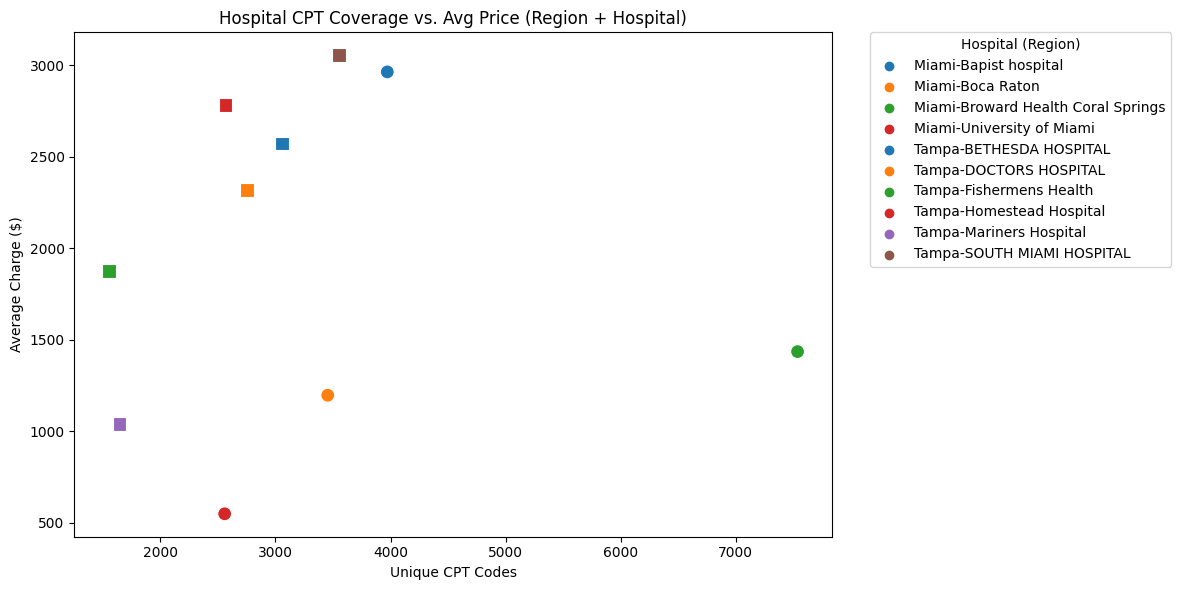

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Group data and keep region info
summary = (
    combined_df.groupby('hospital_name')
    .agg(
        avg_price=('standard_charge|negotiated_dollar', 'mean'),
        cpt_count=('cpt_code', pd.Series.nunique),
        region=('region', 'first')
    )
    .reset_index()
)

# Step 2: Create combined label for legend
summary['label'] = summary['region'] + "-" + summary['hospital_name']

# Step 3: Marker styles by region
region_markers = {
    'Miami': 'o',      # Circle
    'Philly': '^',     # Triangle
    'Tampa': 's'       # Square
}

# Step 4: Plot with custom markers and legend labels
plt.figure(figsize=(12, 6))

for region, marker in region_markers.items():
    subset = summary[summary['region'] == region]
    sns.scatterplot(
        data=subset,
        x='cpt_count',
        y='avg_price',
        hue='label',
        marker=marker,
        s=100,
        legend='full'
    )

plt.title("Hospital CPT Coverage vs. Avg Price (Region + Hospital)")
plt.xlabel("Unique CPT Codes")
plt.ylabel("Average Charge ($)")
plt.legend(title="Hospital (Region)", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


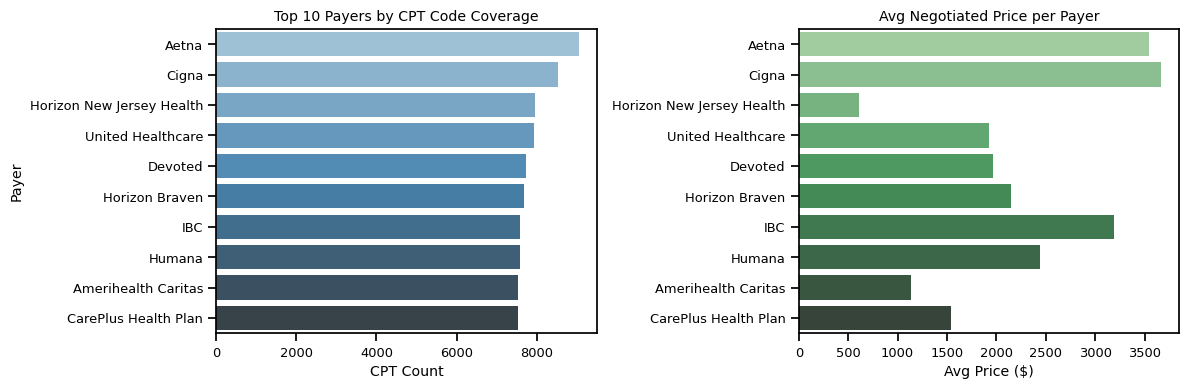

In [0]:
# Step 1: Prepare payer summary
payer_summary = (
    combined_df.groupby('payer_name')
    .agg(
        avg_price=('standard_charge|negotiated_dollar', 'mean'),
        cpt_count=('cpt_code', pd.Series.nunique)
    )
    .round(2)
)

# Step 2: Top 10 by CPT count
top_payers = payer_summary.sort_values(by='cpt_count', ascending=False).head(10).reset_index()

# Step 3: Shorter figure height for PPT
sns.set_context("notebook", font_scale=0.85)  # Reduce font size

fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # shorter height

# CPT Code Coverage
sns.barplot(data=top_payers, y='payer_name', x='cpt_count', palette='Blues_d', ax=axes[0])
axes[0].set_title("Top 10 Payers by CPT Code Coverage")
axes[0].set_xlabel("CPT Count")
axes[0].set_ylabel("Payer")

# Avg Price
sns.barplot(data=top_payers, y='payer_name', x='avg_price', palette='Greens_d', ax=axes[1])
axes[1].set_title("Avg Negotiated Price per Payer")
axes[1].set_xlabel("Avg Price ($)")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

## Statement 2:
###### Cost Transparency for Patients(Find the cheapest hospital per treatment based on the standard_charge|negotiated_dollar.)

In [0]:
%python
import pandas as pd

# Convert the 'standard_charge|negotiated_dollar' column to numeric
sample_df['standard_charge|negotiated_dollar'] = pd.to_numeric(
    sample_df['standard_charge|negotiated_dollar'], 
    errors='coerce'
)

# Group by treatment and hospital to get average charge
avg_price_per_treatment = (
    sample_df.groupby(['description', 'hospital_name'])['standard_charge|negotiated_dollar']
    .mean()
    .reset_index()
)

# Sort by procedure and price to get lowest-cost hospital per procedure
lowest_cost_hospitals = (
    avg_price_per_treatment
    .sort_values(['description', 'standard_charge|negotiated_dollar'])
    .groupby('description')
    .head(1)
    .reset_index(drop=True)
)

# Preview top 10
display(lowest_cost_hospitals.head(10))

description,hospital_name,standard_charge|negotiated_dollar
"""""ARU B2 glycoprotein 1 Ab, IgG""""|""""ARU B2 glycoprotein 1 Ab, IgM""""",DOCTORS HOSPITAL,38.4
"""""ARU Calprotectin, Fecal by Immunoass""""",DOCTORS HOSPITAL,21.99
"""""ARU Culture, Acid Fast Bacilli""""",DOCTORS HOSPITAL,82.2
"""""ARU IgG, CSF""""",DOCTORS HOSPITAL,12.15
"""""ARU Methylmalonic Acid,Quant""""",DOCTORS HOSPITAL,24.05
"""""ARU Mumps Virus Ab, IgG""""",DOCTORS HOSPITAL,15.6
"""""ARU Oligoclonal Bands, CSF""""",DOCTORS HOSPITAL,14.07
"""""ARU SOX1 Antibody, IgG, Immunoblot, Serum""""",DOCTORS HOSPITAL,68.005
"""""ARU SSA-60 (Ro60) (ENA) Antibody, IgG""""",DOCTORS HOSPITAL,10.4
"""""ARU Testosterone, total""""",DOCTORS HOSPITAL,7.92


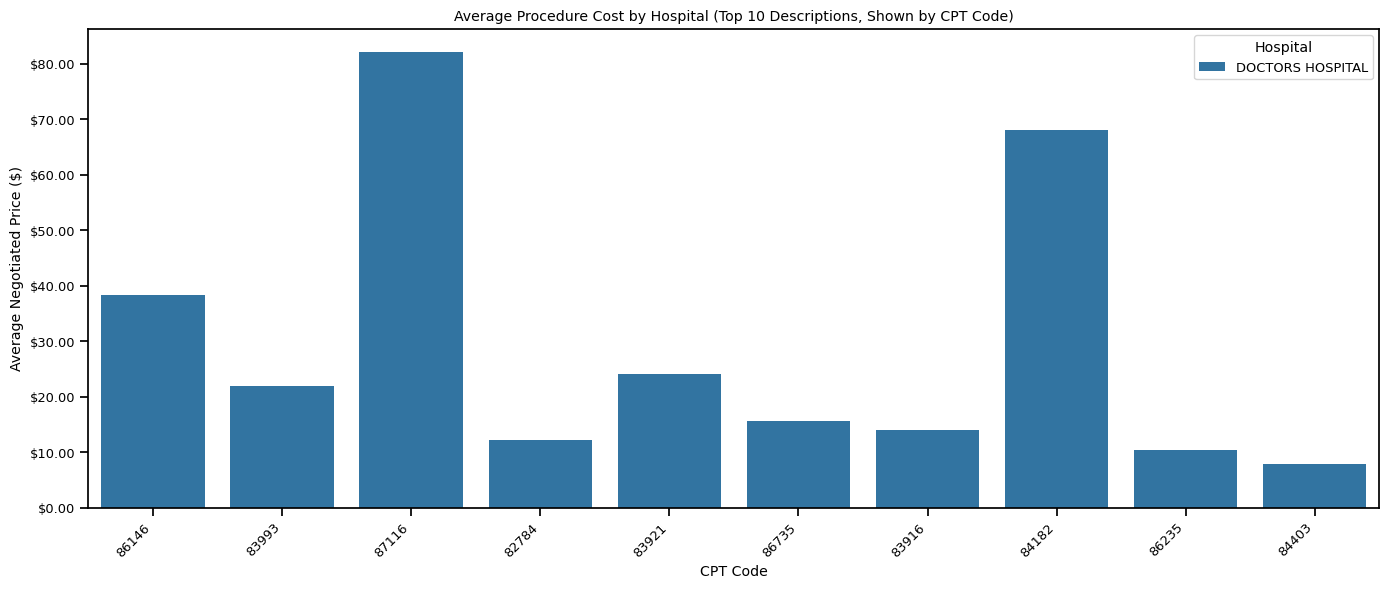

In [0]:
# Step 1: Group by description, hospital, and CPT to get average price
avg_price_per_treatment = (
    sample_df
    .groupby(['description', 'hospital_name', 'cpt_code'])['standard_charge|negotiated_dollar']
    .mean()
    .reset_index()
)

# Step 2: Get top 10 descriptions to include
top10_descriptions = avg_price_per_treatment['description'].unique()[:10]

# Step 3: Filter for only those 10 descriptions
filtered_df = avg_price_per_treatment[avg_price_per_treatment['description'].isin(top10_descriptions)]

# Step 4: Plot using CPT code for x-axis
plt.figure(figsize=(14, 6))
sns.barplot(
    data=filtered_df,
    x='cpt_code',
    y='standard_charge|negotiated_dollar',
    hue='hospital_name'
)

# Step 5: Customize
plt.xlabel('CPT Code')
plt.ylabel('Average Negotiated Price ($)')
plt.title('Average Procedure Cost by Hospital (Top 10 Descriptions, Shown by CPT Code)')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x:,.2f}'))
plt.legend(title='Hospital')
plt.tight_layout()
plt.show()


## Widget:
###### Which are the top 5 lowest charges across the data based on given CPT Code

In [0]:
# --- FIX: Ensure charges are numeric for proper sorting ---
combined_df['standard_charge|negotiated_dollar'] = pd.to_numeric(
    combined_df['standard_charge|negotiated_dollar'], errors='coerce'
)

combined_df['payer_name'] = combined_df['payer_name'].astype(str).str.strip()
combined_df['cpt_code'] = combined_df['cpt_code'].astype(str)

# --- Constants ---
page_size = 20
current_page = 1
total_pages = 1

# --- Widgets for Search Input ---
search_input = widgets.Text(placeholder='Enter CPT code or keyword...', description='Search:')
region_dropdown = widgets.Dropdown(
    options=['All'] + sorted(combined_df['region'].dropna().unique().tolist()),
    value='All', description='Region:')
payer_dropdown = widgets.Dropdown(
    options=['All'] + sorted(combined_df['payer_name'].dropna().unique().tolist()),
    value='All', description='Insurance Company:')
toggle_show_all = widgets.ToggleButton(value=False, description='Show All', icon='list', tooltip='Show all or top 5')
search_button = widgets.Button(description='Search', icon='search', button_style='success')
reset_button = widgets.Button(description='Reset', icon='refresh', button_style='warning')

# Pagination widgets
prev_button = widgets.Button(description='👈', layout=widgets.Layout(width='50px'))
next_button = widgets.Button(description='👉', layout=widgets.Layout(width='50px'))
page_label = widgets.Label()
pagination_controls = widgets.HBox([prev_button, page_label, next_button])

# Output areas
summary_output = widgets.Output()
table_output = widgets.Output()
latest_results = pd.DataFrame()

# --- Download Button ---
export_button = widgets.Button(description='Export CSV', icon='download', button_style='info')

def on_export_click(b):
    if not latest_results.empty:
        export_path = '/dbfs/tmp/filtered_results.csv'  # DBFS path for storing the file
        latest_results.to_csv(export_path, index=False)
        with summary_output:
            print(f"✅ Filtered results exported as 'filtered_results.csv' to {export_path}")
    else:
        with summary_output:
            print("⚠️ No results to export. Please perform a search first.")

export_button.on_click(on_export_click)

# --- Helper Functions ---
def update_pagination_label():
    page_label.value = f"Page {current_page} of {total_pages}"

def cpt_search(cpt_or_keyword, region_input, payer_input, show_all):
    df = combined_df.copy()
    cpt_or_keyword = str(cpt_or_keyword).strip()

    if region_input != 'All':
        df = df[df['region'] == region_input]
    if payer_input != 'All':
        df = df[df['payer_name'] == payer_input]

    if cpt_or_keyword.isdigit():
        df = df[df['cpt_code'] == cpt_or_keyword]
    else:
        df = df[df['description'].str.contains(cpt_or_keyword, case=False, na=False)]

    if df.empty:
        return None, f"No entries found for: '{cpt_or_keyword}' in region: {region_input}, payer: {payer_input}"

    # ✅ Sort results by lowest price
    df_sorted = df.sort_values(by='standard_charge|negotiated_dollar')
    if not show_all:
        df_sorted = df_sorted.head(5)

    return df_sorted, None

def show_paginated_table():
    if latest_results.empty:
        return
    start = (current_page - 1) * page_size
    end = start + page_size
    # Display directly in the notebook
    display(latest_results.iloc[start:end][['cpt_code', 'description', 'standard_charge|negotiated_dollar',
                                            'region', 'payer_name', 'plan_name', 'hospital_name']])

# --- Event Handlers ---
def on_search_click(b=None):
    global current_page, total_pages, latest_results

    summary_output.clear_output()  # Clear previous messages
    table_output.clear_output()    # Clear previous table

    df, error_msg = cpt_search(
        search_input.value,
        region_dropdown.value,
        payer_dropdown.value,
        toggle_show_all.value
    )

    if df is None:
        latest_results = pd.DataFrame()
        total_pages = 1
        current_page = 1
        update_pagination_label()
    else:
        latest_results = df
        total_pages = max(1, (len(df) - 1) // page_size + 1)
        current_page = 1
        update_pagination_label()
        show_paginated_table()

    # Display result summary in summary_output
    with summary_output:
        if error_msg:
            print(error_msg)
        else:
            print(f"🔍 {len(latest_results)} result(s) found for '{search_input.value}'"
                  f" | Region: {region_dropdown.value} | Payer: {payer_dropdown.value}")

def on_reset_click(b):
    global current_page, total_pages, latest_results
    search_input.value = ''
    region_dropdown.value = 'All'
    payer_dropdown.value = 'All'
    toggle_show_all.value = False
    summary_output.clear_output()
    table_output.clear_output()
    current_page = 1
    total_pages = 1
    latest_results = pd.DataFrame()
    update_pagination_label()

def go_to_prev(b):
    global current_page
    if current_page > 1:
        current_page -= 1
        update_pagination_label()
        show_paginated_table()

def go_to_next(b):
    global current_page
    if current_page < total_pages:
        current_page += 1
        update_pagination_label()
        show_paginated_table()

# --- Bind Events ---
search_button.on_click(on_search_click)
search_input.on_submit(on_search_click)
reset_button.on_click(on_reset_click)
prev_button.on_click(go_to_prev)
next_button.on_click(go_to_next)

# --- Title ---
title = widgets.HTML("""
    <h3>🔍 Hospital Price Lookup Tool</h3>
    <p>Search by <b>CPT code</b> or keyword. Filter by <b>region</b> and <b>insurance company</b>. Click <b>Search</b> or press <b>Enter</b>. Reset to start over. Use arrows to navigate pages.</p>
""")

# --- Button Layouts for uniform size ---
button_style = widgets.Layout(width='120px')
search_button.layout = button_style
reset_button.layout = button_style
export_button.layout = button_style
toggle_show_all.layout = widgets.Layout(width='150px')

# --- Inputs Section ---
input_box = widgets.VBox([
    widgets.HTML("<h4>🔎 Search Filters</h4>"),
    widgets.HBox([search_input]),
    widgets.HBox([region_dropdown, payer_dropdown]),
    widgets.HBox([toggle_show_all, reset_button, search_button, export_button])
], layout=widgets.Layout(
    border='solid 2px lightgray',
    padding='15px',
    margin='10px 0px 10px 0px',
    background_color='#f9f9f9',
    border_radius='10px'
))

pagination_controls = widgets.HBox([
    prev_button,
    page_label,
    next_button
], layout=widgets.Layout(
    justify_content='center',
    align_items='center',
    padding='10px'
))

# --- Results Section ---
results_box = widgets.VBox([
    summary_output,
    pagination_controls,
    table_output
], layout=widgets.Layout(
    border='solid 1px lightgray',
    padding='10px',
    background_color='#ffffff',
    border_radius='10px'
))

# --- Display Everything Together ---
display(widgets.VBox([
    title,
    input_box,
    widgets.HTML("<hr>"),
    results_box
]))


In [0]:
%python
# Step 1: Import necessary libraries
from azure.storage.blob import BlobServiceClient
import pandas as pd
from io import StringIO

# Step 2: Define your Azure Blob Storage connection details
connection_string = "DefaultEndpointsProtocol=https;AccountName=healthcaredatastore;AccountKey=roKT3df915NsRDAGMFQhXIZgVIstGL+k3yUKM4IQojZkaLjywwAhqaUWKgT32Vb1ioWq5CgTsIu5+AStnKGG6Q==;EndpointSuffix=core.windows.net"  # actual connection string
container_name = "hospital"  # Your container name
blob_service_client = BlobServiceClient.from_connection_string(connection_string)

# Step 3: Define a function to read CSV files from Azure Blob Storage
def read_csv_from_blob(blob_name):
    blob_client = blob_service_client.get_blob_client(container_name, blob_name)
    blob_data = blob_client.download_blob()
    content = blob_data.readall().decode('utf-8')
    return pd.read_csv(StringIO(content))

# Step 4: Load the data files from the container
philly_df = read_csv_from_blob('Philly_data.csv')
tampa_df = read_csv_from_blob('Tampa_data.csv')
miami_df = read_csv_from_blob('Miami_data.csv')

# Step 5: Clean column names to remove invalid characters
def clean_column_names(df):
    df.columns = df.columns.str.replace('[ ,;{}()\n\t=]', '_', regex=True)
    return df

philly_df = clean_column_names(philly_df)
tampa_df = clean_column_names(tampa_df)
miami_df = clean_column_names(miami_df)

# Step 6: Convert Pandas DataFrames to Spark DataFrames
spark_philly_df = spark.createDataFrame(philly_df)
spark_tampa_df = spark.createDataFrame(tampa_df)
spark_miami_df = spark.createDataFrame(miami_df)

# Step 7: Define the table names
philly_table_name = "philly_data_table"
tampa_table_name = "tampa_data_table"
miami_table_name = "miami_data_table"

# Step 8: Save the Spark DataFrames to Databricks SQL Warehouse (Delta Tables)
spark_philly_df.write.format("delta").mode("overwrite").saveAsTable(philly_table_name)
spark_tampa_df.write.format("delta").mode("overwrite").saveAsTable(tampa_table_name)
spark_miami_df.write.format("delta").mode("overwrite").saveAsTable(miami_table_name)

# Step 9: Optionally, verify the data is saved by querying the tables
display(spark.sql(f"SELECT * FROM {philly_table_name} LIMIT 10"))
display(spark.sql(f"SELECT * FROM {tampa_table_name} LIMIT 10"))
display(spark.sql(f"SELECT * FROM {miami_table_name} LIMIT 10"))

/root/.ipykernel/1908/command-4904810147174315-3123893945:16: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(StringIO(content))
/databricks/spark/python/pyspark/sql/pandas/conversion.py:413: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Expected bytes, got a 'int' object
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


hospital_name,description,setting,payer_name,plan_name,standard_charge|negotiated_dollar,cpt_code
Childrens Hospital of Philadelphia,Istat4 Blood Gas,outpatient,Aetna Better Health,All plan types,96.15,82803
Childrens Hospital of Philadelphia,Istat4 Lactate,outpatient,Aetna Better Health,All plan types,98.13,83605
Childrens Hospital of Philadelphia,Istat Inr,outpatient,Aetna Better Health,All plan types,84.1,85610
Childrens Hospital of Philadelphia,Blood Product Admin < 2 Hrs,outpatient,Aetna Better Health,All plan types,770.61,36430
Childrens Hospital of Philadelphia,Blood Product Admin 2 Hrs,outpatient,Aetna Better Health,All plan types,810.92,36430
Childrens Hospital of Philadelphia,Blood Product Admin 2.5 Hrs,outpatient,Aetna Better Health,All plan types,853.17,36430
Childrens Hospital of Philadelphia,Blood Product Admin 3 Hrs,outpatient,Aetna Better Health,All plan types,935.73,36430
Childrens Hospital of Philadelphia,Blood Product Admin 3.5 Hrs,outpatient,Aetna Better Health,All plan types,1102.8,36430
Childrens Hospital of Philadelphia,Blood Product Admin 4 Hrs,outpatient,Aetna Better Health,All plan types,1141.81,36430
Childrens Hospital of Philadelphia,Blood Product Admin 4.5 Hrs,outpatient,Aetna Better Health,All plan types,1186.01,36430


hospital_name,description,setting,payer_name,plan_name,standard_charge|negotiated_dollar,cpt_code
Fishermens Health,BMT-Chimerism & CD56 cells,Outpatient,AETNA,AETNA TIER 2,389.35,81268
Fishermens Health,BMT-HLA Class I antibody HD,Outpatient,AETNA,AETNA HMO EXCHANGE,351.0,86832
Fishermens Health,BMT-Post transplant engraftment,Outpatient,AETNA,AETNA BETTER HEALTH MEDICAID,198.25,81267
Fishermens Health,BMT-pre transplant profile,Outpatient,INTERNATIONAL,INTERNATIONAL AETNA,389.35,81265
Fishermens Health,Amikacin Peak|Amikacin Trough,Outpatient,AFFORDABLE,AFFORDABLE PPO,27.95,80150
Fishermens Health,BMT-Chimerism CD33 cells (C)|BMT-Chimerism CD66b cells (C),Outpatient,INTERNATIONAL,INTERNATIONAL AETNA,159.9,81268
Fishermens Health,Insert/replace leadless pacer,Inpatient,AETNA,AETNA BETTER HEALTH MEDICAID,33666.75,33274
Fishermens Health,B-cell Gene Rearrangement-NG,Outpatient,AETNA,AETNA HMO,362.05,81479
Fishermens Health,Neotype Lymphoma Profile-81450-NG,Outpatient,BLUE CROSS,BCBS PHS CAH,1227.85,81450
Fishermens Health,Vacc Menveo 0.5ml inj kit,Outpatient,AMERIHEALTH,AMERIHTH CARITAS NXT EX,257.4,90734


Unnamed:_0,hospital_name,description,setting,payer_name,plan_name,standard_charge|negotiated_dollar,cpt_code
0,Bapist hospital,OneBlood CBC w auto diff,both,DIMENSION HEALTH PLAN,DIMENSION 2,22.5,85025
1,Bapist hospital,Orbit face neck MRI wwo con,both,DIMENSION HEALTH PLAN,DIMENSION 2,5562.9,70543
2,Bapist hospital,Orbit sella pf ear ct w con UC,both,DIMENSION HEALTH PLAN,DIMENSION 2,5360.4,70481
3,Bapist hospital,Orbit sella pf ear ct wo c UC,both,DIMENSION HEALTH PLAN,DIMENSION 2,4953.6,70480
4,Bapist hospital,Orbit sella pf ear CT wo con|PET Orbit sella pf ear CT wo con,both,DIMENSION HEALTH PLAN,DIMENSION 2,4646.7,70480
5,Bapist hospital,Inhaler demo 1 time per day UC,both,DIMENSION HEALTH PLAN,DIMENSION 2,164.7,94664
6,Bapist hospital,Inj im/subq UC,both,DIMENSION HEALTH PLAN,DIMENSION 2,94.5,96372
7,Bapist hospital,Inj IVP ad sam medq30 1sit UC,both,DIMENSION HEALTH PLAN,DIMENSION 2,94.5,96376
8,Bapist hospital,Injection for venography surgi,both,DIMENSION HEALTH PLAN,DIMENSION 2,381.6,36005
9,Bapist hospital,Ins tun centlin wsubc port 5up,both,DIMENSION HEALTH PLAN,DIMENSION 2,5454.0,36561


In [0]:
# --------------------------------------------------------------
# Export THIS notebook, add empty 'state' to every widgets block,
# save fixed copy under /dbfs/FileStore/, and show download link.
# --------------------------------------------------------------

%pip install --quiet nbformat requests   # one‑time (tiny, ~1 s)

import nbformat, requests, uuid, os, json
from pathlib import Path

# --- 1) workspace context --------------------------------------------------
ctx        = dbutils.notebook.entry_point.getDbutils().notebook().getContext()
nb_path    = ctx.notebookPath().get()              # workspace path of this notebook
api_root   = ctx.apiUrl().get().rstrip("/")        # https://adb‑xxxx.azuredatabricks.net
token      = ctx.apiToken().get()                  # scoped token
browser_host = ctx.browserHostName().get()         # adb‑xxxx.azuredatabricks.net

# --- 2) pull notebook as .ipynb -------------------------------------------
resp = requests.get(
    f"{api_root}/api/2.0/workspace/export",
    headers={"Authorization": f"Bearer {token}"},
    params = {"path": nb_path, "format": "JUPYTER"}
)
resp.raise_for_status()

raw_ipynb = nbformat.reads(resp.text, as_version=4)

# --- 3) add empty 'state' where missing ------------------------------------
if "widgets" in raw_ipynb.metadata:
    raw_ipynb.metadata["widgets"]["state"] = raw_ipynb.metadata["widgets"].get("state", {})

for cell in raw_ipynb.cells:
    w = cell.metadata.get("widgets")
    if w is not None:
        w["state"] = w.get("state", {})

# --- 4) write fixed file to DBFS /FileStore -------------------------------
fname_base = Path(nb_path).name.replace("/", "_")
fixed_path_dbfs = f"/dbfs/FileStore/{fname_base}_fixed.ipynb"
nbformat.write(raw_ipynb, fixed_path_dbfs)

# --- 5) show clickable download link --------------------------------------
file_url = fixed_path_dbfs.replace("/dbfs", "/files")        # /files maps to /dbfs
download_link = f"https://{browser_host}{file_url}"

displayHTML(f"""
<div style='font-size:16px'>
✅ Clean notebook saved!<br>
<a href="{download_link}" target="_blank">⬇️ Download patched .ipynb</a><br>
(If the link 403s, copy‑paste this URL into a new tab.)<br><br>
<code>{download_link}</code>
</div>
""")


Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


---------------------------------------------------------------------------
ValidationError                           Traceback (most recent call last)
File <command-5040752045907283>, line 26
     19 resp = requests.get(
     20     f"{api_root}/api/2.0/workspace/export",
     21     headers={"Authorization": f"Bearer {token}"},
     22     params = {"path": nb_path, "format": "JUPYTER"}
     23 )
     24 resp.raise_for_status()
---> 26 raw_ipynb = nbformat.reads(resp.text, as_version=4)
     28 # --- 3) add empty 'state' where missing ------------------------------------
     29 if "widgets" in raw_ipynb.metadata:

File /databricks/python/lib/python3.10/site-packages/nbformat/__init__.py:90, in reads(s, as_version, capture_validation_error, **kwargs)
     88 nb = reader.reads(s, **kwargs)
     89 if as_version is not NO_CONVERT:
---> 90     nb = convert(nb, as_version)
     91 try:
     92     validate(nb)

File /databricks/python/lib/python3.10/site-packages/nbformat/converter.py:63

In [0]:
# --------------------------------------------------------------
# Export THIS notebook, patch widget‑metadata, save fixed copy,
# and show a 1‑click download link
# --------------------------------------------------------------

%pip install --quiet nbformat requests

import base64, nbformat, requests, uuid
from pathlib import Path

# 1) workspace context
ctx          = dbutils.notebook.entry_point.getDbutils().notebook().getContext()
nb_path      = ctx.notebookPath().get()                    # workspace path of this notebook
api_root     = ctx.apiUrl().get().rstrip("/")              # https://adb‑xxx.azuredatabricks.net
token        = ctx.apiToken().get()
browser_host = ctx.browserHostName().get()                 # adb‑xxx.azuredatabricks.net

# 2) export the notebook as JUPYTER (.ipynb) –> returns base64
resp = requests.get(
    f"{api_root}/api/2.0/workspace/export",
    headers = {"Authorization": f"Bearer {token}"},
    params  = {"path": nb_path, "format": "JUPYTER"}
)
resp.raise_for_status()
b64 = resp.json()["content"]
ipynb_text = base64.b64decode(b64).decode("utf-8")
nb = nbformat.reads(ipynb_text, as_version=4)

# 3) add empty 'state' objects so GitHub is happy
if "widgets" in nb.metadata:
    nb.metadata["widgets"]["state"] = nb.metadata["widgets"].get("state", {})
for c in nb.cells:
    w = c.metadata.get("widgets")
    if w is not None:
        w["state"] = w.get("state", {})

# 4) write patched file to DBFS /FileStore
fname = Path(nb_path).name.replace("/", "_") + "_fixed.ipynb"
fixed_path_dbfs = f"/dbfs/FileStore/{fname}"
nbformat.write(nb, fixed_path_dbfs)

# 5) direct download link (/files maps to /dbfs)
file_url = fixed_path_dbfs.replace("/dbfs", "/files")
download_link = f"https://{browser_host}{file_url}"

displayHTML(f"""
<div style='font-size:16px'>
✅ Patched notebook saved!<br>
<a href="{download_link}" target="_blank">⬇️ Download .ipynb</a><br><br>
<code>{download_link}</code>
</div>
""")


Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
File /databricks/python/lib/python3.10/site-packages/nbformat/__init__.py:200, in write(nb, fp, version, capture_validation_error, **kwargs)
    199 try:
--> 200     fp.write(s)
    201     if not s.endswith("\n"):

AttributeError: 'str' object has no attribute 'write'

During handling of the above exception, another exception occurred:

FileNotFoundError                         Traceback (most recent call last)
File <command-5040752045907284>, line 40
     38 fname = Path(nb_path).name.replace("/", "_") + "_fixed.ipynb"
     39 fixed_path_dbfs = f"/dbfs/FileStore/{fname}"
---> 40 nbformat.write(nb, fixed_path_dbfs)
     42 # 5) direct download link (/files maps to /dbfs)
     43 file_url = fixed_path_dbfs.replace("/dbfs", "/files")

File /databricks/python/lib/python3.10/site-packages/nbformat/__init__.py:204, in write(nb, fp, version,

In [0]:
# --------------------------------------------------------------
# Export this notebook, patch widget metadata, copy patched file
# into DBFS FileStore, and give a download link.
# --------------------------------------------------------------

%pip install --quiet nbformat requests

import base64, nbformat, requests, uuid, tempfile, os, shutil
from pathlib import Path

# --- 1) workspace / context -----------------------------------
ctx          = dbutils.notebook.entry_point.getDbutils().notebook().getContext()
nb_path      = ctx.notebookPath().get()
api_root     = ctx.apiUrl().get().rstrip("/")
token        = ctx.apiToken().get()
browser_host = ctx.browserHostName().get()

# --- 2) export notebook as base64 .ipynb -----------------------
resp = requests.get(
    f"{api_root}/api/2.0/workspace/export",
    headers = {"Authorization": f"Bearer {token}"},
    params  = {"path": nb_path, "format": "JUPYTER"}
)
resp.raise_for_status()
ipynb_text = base64.b64decode(resp.json()["content"]).decode("utf-8")
nb = nbformat.reads(ipynb_text, as_version=4)

# --- 3) add empty "state" to every widgets block ---------------
if "widgets" in nb.metadata:
    nb.metadata["widgets"]["state"] = nb.metadata["widgets"].get("state", {})
for c in nb.cells:
    w = c.metadata.get("widgets")
    if w is not None:
        w["state"] = w.get("state", {})

# --- 4) write to local tmp and copy into DBFS ------------------
fname = Path(nb_path).name.replace("/", "_") + "_fixed.ipynb"
local_tmp = os.path.join(tempfile.gettempdir(), fname)
nbformat.write(nb, local_tmp)

dbfs_path = f"dbfs:/FileStore/{fname}"
dbutils.fs.cp(f"file:{local_tmp}", dbfs_path)

# --- 5) direct browser URL (/files maps to /dbfs) --------------
download_url = f"https://{browser_host}/files/{fname}"

displayHTML(f"""
<div style='font-size:16px'>
✅ Clean notebook saved to <code>{dbfs_path}</code><br>
<a href="{download_url}" target="_blank">⬇️ Download patched .ipynb</a><br><br>
<code>{download_url}</code>
</div>
""")


Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
